In [1]:
import os
import pandas as pd
import re
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

def sample_type(barcode):
    # example: get "01" from TCGA-W5-A22X-01A
    # 00-09 tumor; 10-19 normal; 20-29 control
    match = re.search(r'-([0-2][0-9])[A-Z]*', barcode)
    if match:
        code = int(match.group(1))
        if code < 10:
            return "TUMOR"
        elif code < 20:
            return "NORMAL"
        elif code < 30:
            return "CONTROL"
        else:
            raise SyntaxError("Its not a TCGA barcode format.")

def open_vcf(vcf_file):
    # Find the line number containing string "#CHROM"
    with open(vcf_file, 'r') as f:
        for line_ind, line in enumerate(f):
            if line.startswith('#CHROM'):
                break
    
    # load data and skip headers
    df = pd.read_csv(vcf_file, sep='\t', header=line_ind, dtype=object)
    return df

def parse_info(format, info_str):
    '''
    GT: 基因型 (Genotype)
    DP: 深度 (Depth)
    AD: 等位基因深度 (Allelic Depth)，通常是指各等位基因的深度
    BQ: 鹼基品質 (Base Quality)
    AF = FREQ: Allele Frequency(等位基因頻率) = AD/DP
    RD: Reference Depth(参考序列深度)
    
    varscan, GT:GQ:DP:RD:AD:FREQ:DP4, 0/0:.:68:65:2:2.99%:15,50,1,1
    mutect2, GT:AD:AF:DP:F1R2:F2R1, 0/1:12,4:0.275:16:8,2:4,2
    mutect2, GT:AD:AF:DP:F1R2:F2R1, 0/1/2:13,3,2:0.181,0.145:18:3,1,1:10,2,1
    muse, GT:DP:AD:BQ:SS, 0/1:19:14,5:31,31:2

    * mutect 2 multiallelic問題已經在前處理中使用bcftools norm拆分 *
    '''
    info_list = info_str.split(":")
    # varscan format
    if format == "GT:GQ:DP:RD:AD:FREQ:DP4":
        DP_index, AD_index, AF_index = 2, 4, 5
        DP, AD = int(info_list[DP_index]), int(info_list[AD_index])
        AF = float(info_list[AF_index].replace("%", ""))/100
        
    # mutect2 format
    elif format == "GT:AD:AF:DP:F1R2:F2R1" or format == "GT:AD:AF:DP:F1R2:F2R1:PGT:PID:PS":
        DP_index, AD_index, AF_index = 3, 1, 2
        AD = int(info_list[AD_index].split(",")[1])
        DP, AF = int(info_list[DP_index]), float(info_list[AF_index])
        
    # muse format
    elif format == "GT:DP:AD:BQ:SS":
        DP_index, AD_index = 1, 2
        AD = int(info_list[AD_index].split(",")[1])
        DP = int(info_list[DP_index])
        AF = AD / DP
    else:
        raise ValueError(f"{format} is an Unexpected format")
    return DP, AD, AF

def preprocess_vcf(vcf_file):
    vcf_df = open_vcf(vcf_file)
    vcf_df = vcf_df.loc[vcf_df.FILTER == "PASS"] # keep "PASS"
    
    # keep only chr1-22 or XY
    vcf_df = vcf_df[vcf_df['#CHROM'].str.contains(r'^chr(?:[1-9]|1\d|2[0-2]|X|Y)$')]
    
    # make sure TUMOR/NORMAL is upper
    vcf_df.columns = ['CHROM'] + list(vcf_df.columns[1:].str.upper()) 
    
    # reindex to CHROM|POS|REF|ALT and drop 7 columns
    vcf_df.index = vcf_df.loc[:, ["CHROM", "POS", "REF", "ALT"]].apply(lambda row: "|".join(row.astype(str)), axis=1)
    vcf_df = vcf_df.drop(columns=["CHROM", "POS", "REF", "ALT", 'ID', 'QUAL', 'FILTER'])
    
    # if no columns TUMOR/NORMAL(mutect2) rename last 2 columns
    if "TUMOR" not in vcf_df.columns or "NORMAL" not in vcf_df.columns :
        vcf_df = vcf_df.rename(columns={vcf_df.columns[-1]: sample_type(vcf_df.columns[-1]), 
                                        vcf_df.columns[-2]: sample_type(vcf_df.columns[-2])})
    # extract DP AD AF columns from TUMOR columns
    vcf_df[['DP', 'AD', 'AF']] = vcf_df.apply(lambda row: parse_info(row['FORMAT'], row['TUMOR']), axis=1, result_type='expand')
    
    return vcf_df

def vcf_df_filter(vcf_df, DP=30, AD=3, AF=0.05):
    filter = (vcf_df.DP >= DP) & (vcf_df.DP >= AD) & (vcf_df.AF > AF)
    return vcf_df[filter]

def venn_plot(caller_df, n_callers, plot_path):
    subset_sizes = {}
    for comb in itertools.product([0, 1], repeat=n_callers):
        filters = np.where(np.array(comb) == 1, True, False)
        subset_sizes["".join(map(str, comb))] = caller_df.loc[:, filters].all(axis=1).sum()
    plt.figure(figsize=(8, 10))
    venn3(subsets=subset_sizes, set_labels=caller_df.columns)
    plt.title(f'Venn Diagram: {", ".join(caller_df.columns)}')
    plt.savefig(plot_path)

TCGA-W5-AA2R
TCGA-W5-AA2X
TCGA-W5-AA33
TCGA-W5-AA2Z
TCGA-4G-AAZT
TCGA-4G-AAZR
TCGA-W7-A93P
TCGA-W7-A93O
TCGA-4G-AAZF
TCGA-W7-A93N


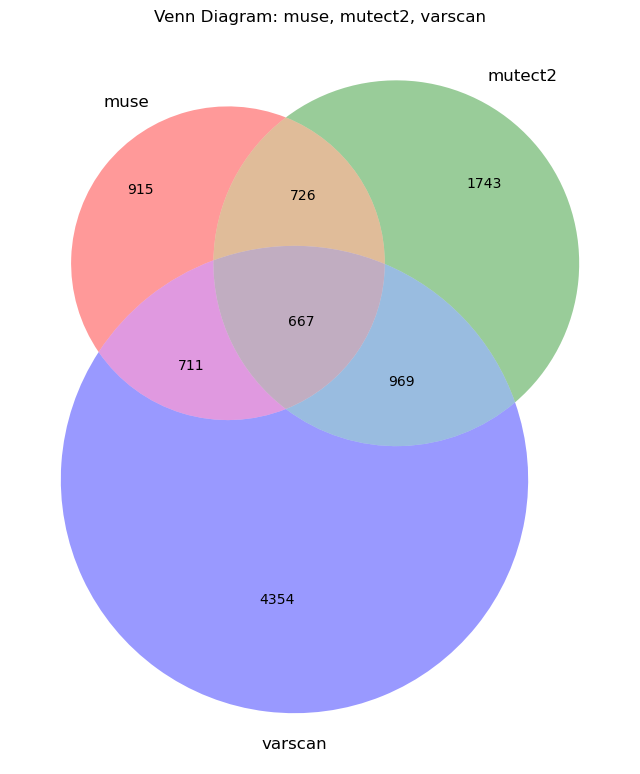

In [4]:
pd.set_option('future.no_silent_downcasting', True)
os.chdir("/home/data/dataset/CHOL_10sample/")
sample_sheet = pd.read_csv("./gdc_sample_sheet.2024-02-26.tsv", sep="\t")

all_case_df = pd.DataFrame()
caller_list = ["muse", "mutect2", "varscan"]

unique_case_IDs = sample_sheet.loc[:, "Case ID"].unique()
caller_stat_df = pd.DataFrame(columns=["all"] 
                                    + [f"{caller}_raw" for caller in caller_list]
                                    + [f"{caller}_filtered" for caller in caller_list]
                                    + ["2_caller"],
                              index=pd.Index(unique_case_IDs, name="case_ID"))
for case_ID in unique_case_IDs: # ["TCGA-W5-AA2R"]:##
    print(case_ID)
    result_dict = {
        "muse": preprocess_vcf(vcf_file=f"./variants_calling/muse/{case_ID}.MuSE.vcf"),
        "mutect2": preprocess_vcf(vcf_file=f"./variants_calling/mutect/{case_ID}.splited.vcf"),
        "varscan": pd.concat([
            preprocess_vcf(vcf_file=f"./variants_calling/varscan/{case_ID}.varscan.indel.Somatic.hc.vcf"),
            preprocess_vcf(vcf_file=f"./variants_calling/varscan/{case_ID}.varscan.snp.Somatic.hc.vcf")
        ])
    }
    # merge all caller and filter DP, AD, AF -> case_df
    case_df = pd.DataFrame()
    for package_name, caller_df in result_dict.items():
        caller_stat_df.loc[case_ID, f"{package_name}_raw"] = len(caller_df)
        filtered_df = vcf_df_filter(caller_df)
        caller_stat_df.loc[case_ID, f"{package_name}_filtered"] = len(filtered_df)
        filtered_df = pd.DataFrame(True, index=filtered_df.index, columns=[package_name])
        case_df = pd.concat([case_df, filtered_df], axis=1)
    case_df = case_df.fillna(False).infer_objects(copy=False)
    
    # filter at least 2 caller hit
    caller_2hit_filter = case_df.loc[:, caller_list].sum(axis=1) >= 2
    caller_stat_df.loc[case_ID, "all"] = len(case_df)
    caller_stat_df.loc[case_ID, "2_caller"] = caller_2hit_filter.sum()
    case_df["case"] = case_ID
    all_case_df = pd.concat([all_case_df, case_df])

# all_case_df
all_case_df_gb = all_case_df.groupby(all_case_df.index)
all_case_df.groupby("case").size()

# merge same ID
all_case_df_dedup = all_case_df_gb.agg({'muse':'max',
                                          'mutect2':'max',
                                          'varscan':'max',
                                          'case': lambda x: ','.join(x)})
callers_2_hit = all_case_df_dedup.loc[:, caller_list].sum(axis=1) >= 2
all_case_df_2_callers = all_case_df_dedup[callers_2_hit] 
splited_info = all_case_df_2_callers.reset_index()['index'].str.split("|", expand=True)
splited_info.columns = ["#CHROM", "POS", "REF",  "ALT"]
splited_info['callers'] = all_case_df_2_callers.apply(lambda row: ';'.join([caller for caller, value in row[caller_list].items() if value]), axis=1).values
splited_info['case'] = all_case_df_2_callers['case'].values

sorter = ['chr' + str(i) for i in range(1, 23)] + ['chrX', 'chrY']
splited_info['#CHROM'] = splited_info['#CHROM'].astype('category')
splited_info['#CHROM'] = splited_info['#CHROM'].cat.set_categories(sorter)
splited_info = splited_info.sort_values(by=['#CHROM', 'POS'])
splited_info = splited_info.reset_index(drop=True)   

# save files
splited_info.to_csv("/home/data/dataset/CHOL_10sample/variants_calling/all_samples_2callers.dingyang3.vcf", sep="\t", index=False)
caller_stat_df.to_csv("/home/data/dataset/CHOL_10sample/variants_calling/caller_stat_df.csv")
venn_plot(all_case_df.loc[:, caller_list], 
          3, 
          "/home/data/dataset/CHOL_10sample/variants_calling/venn.png")

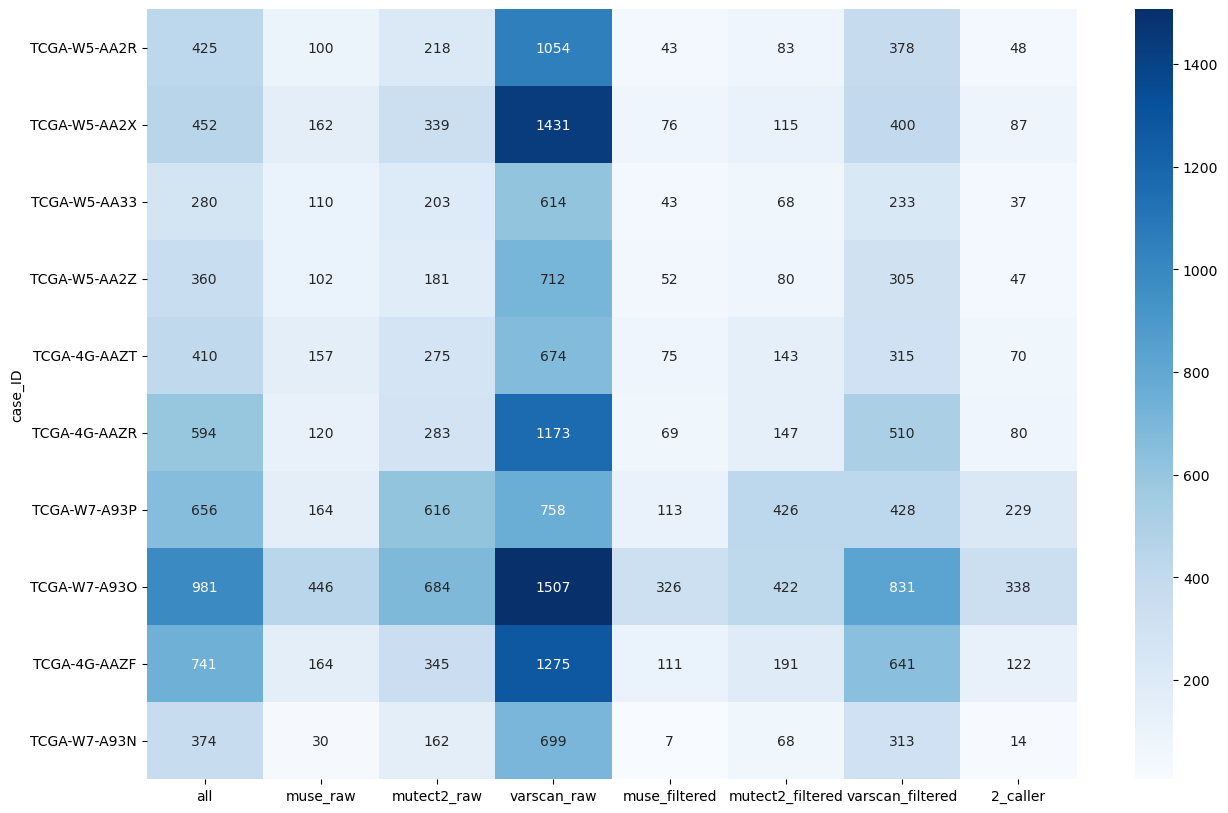

In [5]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(caller_stat_df.astype(np.int64), cmap="Blues", annot=True, ax=ax, fmt="d")
plt.show()

In [6]:
sorter = ['chr'+str(i) for i in range(1, 23)] + ['chrX', 'chrY']
splited_info['#CHROM'] = splited_info['#CHROM'].astype('category')
splited_info['#CHROM'] = splited_info['#CHROM'].astype('category')
splited_info['POS'] = splited_info['POS'].astype(np.int64)
splited_info = splited_info.sort_values(by=['#CHROM', 'POS'])
splited_info = splited_info.reset_index(drop=True)   
#splited_info.to_csv("/home/data/dataset/CHOL_10sample/variants_calling/all_samples_2callers.dingyang3.vcf", sep="\t", index=False)
splited_info

,#CHROM,POS,REF,ALT,callers,case
0,chr1,1390825,G,A,mutect2;varscan,TCGA-W5-AA2X
1,chr1,1392808,G,T,mutect2;varscan,TCGA-W7-A93N
2,chr1,2588432,C,T,muse;mutect2;varscan,TCGA-W7-A93O
3,chr1,6109916,G,T,mutect2;varscan,TCGA-W7-A93O
4,chr1,6109917,T,TTG,mutect2;varscan,TCGA-W7-A93O
...,...,...,...,...,...,...
1069,chrX,152701890,A,T,muse;mutect2;varscan,TCGA-W5-AA2Z
1070,chrX,154652459,T,C,muse;mutect2;varscan,TCGA-4G-AAZF
1071,chrY,11138810,A,G,mutect2;varscan,TCGA-W5-AA2X
1072,chrY,12859165,A,T,muse;varscan,TCGA-W5-AA2X


In [68]:
result_df = splited_info.copy()
result_df["QUAL"] = "."
result_df["ID"] = "."
result_df["FILTER"] = "PASS"
result_df["INFO"] = ""
result_df = result_df.reindex(columns = ["#CHROM", "POS", "ID", "REF", "ALT", "FILTER", "INFO", "CALLER", "CASE"])
result_df.to_csv("/home/data/dataset/CHOL_10sample/variants_calling/all_samples_2callers.dingyang4.vcf", sep="\t", index=False)

cache_version = "103"
dir_cache="/home/data/database/vep"
assembly="GRCh38"
threads=20
assembly_fasta="/home/data/data_thousand/gatk_index/Homo_sapiens_assembly38.fasta"
env_name = "vep"
vep_command = [
    "vep", 
    "-i", "/home/data/dataset/CHOL_10sample/variants_calling/all_samples_2callers.dingyang4.vcf", 
    "-o", "/home/data/dataset/CHOL_10sample/variants_calling/all_samples_2callers.dingyang4.vep.vcf", 
    "--vcf", 
    "--cache", "--dir_cache", dir_cache, "--cache_version", cache_version, 
    "--assembly", assembly, "--force_overwrite", 
    "--fork", str(threads), 
    "--offline", "--no_stats", "--everything", "--pick", 
    "--fasta", assembly_fasta
]
import subprocess
def run_command(command):
    process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True, executable='/bin/bash')
    output, error = process.communicate()
    return output, error
command = f"source $HOME/miniconda3/etc/profile.d/conda.sh; conda run -n {env_name} {' '.join(vep_command)}"
output, error = run_command(command)
print(output, error)


Argument "." isn't numeric in addition (+) at /home/dingyangliu/miniconda3/envs/vep/share/ensembl-vep-111.0-0/modules/Bio/EnsEMBL/VEP/Parser/VCF.pm line 252, <__ANONIO__> line 735.
Argument "." isn't numeric in addition (+) at /home/dingyangliu/miniconda3/envs/vep/share/ensembl-vep-111.0-0/Bio/EnsEMBL/Variation/Utils/Sequence.pm line 970, <__ANONIO__> line 735.



b'' None


In [ ]:
splited_info["QUAL"] = "."
splited_info["ID"] = "."
splited_info["INFO"] = "test"
splited_info["FORMAT"] = "test2"
splited_info = splited_info.reindex(columns = ["#CHROM", "POS", "ID", "REF", "ALT", "QUAL", "FILTER", "INFO", "callers", "case"])
splited_info.to_csv("/home/data/dataset/CHOL_10sample/variants_calling/all_samples_2callers.dingyang4.vcf", sep="\t", index=False)


Use of uninitialized value $ref in join or string at /home/dingyangliu/miniconda3/envs/vep/share/ensembl-vep-111.0-0/modules/Bio/EnsEMBL/VEP/Parser/VCF.pm line 235, <__ANONIO__> line 817.
Use of uninitialized value in split at /home/dingyangliu/miniconda3/envs/vep/share/ensembl-vep-111.0-0/Bio/EnsEMBL/IO/Parser/BaseVCF4.pm line 447, <__ANONIO__> line 817.
Use of uninitialized value $ref in subtraction (-) at /home/dingyangliu/miniconda3/envs/vep/share/ensembl-vep-111.0-0/modules/Bio/EnsEMBL/VEP/Parser/VCF.pm line 252, <__ANONIO__> line 817.
Use of uninitialized value in string eq at /home/dingyangliu/miniconda3/envs/vep/share/ensembl-vep-111.0-0/modules/Bio/EnsEMBL/VEP/Parser/VCF.pm line 257, <__ANONIO__> line 817.
Use of uninitialized value $ref in concatenation (.) or string at /home/dingyangliu/miniconda3/envs/vep/share/ensembl-vep-111.0-0/modules/Bio/EnsEMBL/VEP/Parser/VCF.pm line 337, <__ANONIO__> line 817.
Use of uninitialized value in sprintf at /home/dingyangliu/miniconda3/envs

b'' None


In [ ]:
splited_info.to_csv("/home/data/dataset/CHOL_10sample/variants_calling/all_samples_2callers.dingyang3.vcf", sep="\t", index=False)
caller_stat_df.to_csv("/home/data/dataset/CHOL_10sample/variants_calling/caller_stat_df.csv")

In [64]:
vep_vcf = "variants_calling/all_samples_2callers.dingyang4.vep.vcf"
vep_df = open_vcf(vep_vcf)
with open(vep_vcf) as vcf:
    lines = vcf.readlines()
info_line_index = 2
format = lines[info_line_index].split("Format: ")[1].replace('">\n', "")
format_list = format.split("|")
vep_df = pd.DataFrame(vep_df["VEP"].str.split("|", expand=True).values,
                      columns=format_list)
maf = pd.concat([result_df.drop(["FORMAT", "VEP"], axis=1), vep_df], axis=1)

In [65]:

maf

,#CHROM,POS,ID,REF,ALT,QUAL,callers,case,Allele,Consequence,...,MAX_AF_POPS,CLIN_SIG,SOMATIC,PHENO,PUBMED,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,TRANSCRIPTION_FACTORS
0,chr1,1390825,.,G,A,.,mutect2;varscan,TCGA-W5-AA2X,CSQ=A,missense_variant,...,,,0&1,0&1,,,,,,
1,chr1,1392808,.,G,T,.,mutect2;varscan,TCGA-W7-A93N,CSQ=T,intron_variant,...,,,,,,,,,,
2,chr1,2588432,.,C,T,.,muse;mutect2;varscan,TCGA-W7-A93O,CSQ=T,downstream_gene_variant,...,,,,,,,,,,
3,chr1,6109916,.,G,T,.,mutect2;varscan,TCGA-W7-A93O,CSQ=T,missense_variant,...,,,,,,,,,,
4,chr1,6109917,.,T,TTG,.,mutect2;varscan,TCGA-W7-A93O,CSQ=TG,frameshift_variant,...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1069,chrX,152701890,.,A,T,.,muse;mutect2;varscan,TCGA-W5-AA2Z,CSQ=T,3_prime_UTR_variant,...,,,,,,,,,,
1070,chrX,154652459,.,T,C,.,muse;mutect2;varscan,TCGA-4G-AAZF,CSQ=C,missense_variant,...,,,,,,,,,,
1071,chrY,11138810,.,A,G,.,mutect2;varscan,TCGA-W5-AA2X,CSQ=G,intergenic_variant,...,,,,,,,,,,
1072,chrY,12859165,.,A,T,.,muse;varscan,TCGA-W5-AA2X,CSQ=T,intron_variant,...,,,,,,,,,,


In [54]:
vep_df["HGVSp"]

0               ENSP00000383611.3:p.Arg234Trp
1                                            
2                                            
3              ENSP00000262450.3:p.Asn1819Lys
4       ENSP00000262450.3:p.Asn1819ThrfsTer44
                        ...                  
1069                                         
1070            ENSP00000247306.4:p.Met148Val
1071                                         
1072                                         
1073                                         
Name: HGVSp, Length: 1074, dtype: object

In [55]:
vep_df

,Allele,Consequence,IMPACT,SYMBOL,Gene,Feature_type,Feature,BIOTYPE,EXON,INTRON,...,MAX_AF_POPS,CLIN_SIG,SOMATIC,PHENO,PUBMED,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,TRANSCRIPTION_FACTORS
0,CSQ=A,missense_variant,MODERATE,CCNL2,ENSG00000221978,Transcript,ENST00000400809,protein_coding,6/11,,...,,,0&1,0&1,,,,,,
1,CSQ=T,intron_variant,MODIFIER,CCNL2,ENSG00000221978,Transcript,ENST00000400809,protein_coding,,5/10,...,,,,,,,,,,
2,CSQ=T,downstream_gene_variant,MODIFIER,MMEL1,ENSG00000142606,Transcript,ENST00000378412,protein_coding,,,...,,,,,,,,,,
3,CSQ=T,missense_variant,MODERATE,CHD5,ENSG00000116254,Transcript,ENST00000262450,protein_coding,38/42,,...,,,,,,,,,,
4,CSQ=TG,frameshift_variant,HIGH,CHD5,ENSG00000116254,Transcript,ENST00000262450,protein_coding,38/42,,...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1069,CSQ=T,3_prime_UTR_variant,MODIFIER,MAGEA3,ENSG00000221867,Transcript,ENST00000370278,protein_coding,3/3,,...,,,,,,,,,,
1070,CSQ=C,missense_variant,MODERATE,CTAG2,ENSG00000126890,Transcript,ENST00000247306,protein_coding,2/2,,...,,,,,,,,,,
1071,CSQ=G,intergenic_variant,MODIFIER,,,,,,,,...,,,,,,,,,,
1072,CSQ=T,intron_variant,MODIFIER,USP9Y,ENSG00000114374,Transcript,ENST00000338981,protein_coding,,45/45,...,,,,,,,,,,


In [37]:
vep_df["VEP"].str.split("|", expand=True))
vep_df

AttributeError: Can only use .str accessor with string values!

In [ ]:
result_df
vep_df = pd.read_csv(vep_vcf, sep="\t")
vep_df

In [ ]:
import subprocess
input_vcf = "variants_calling/all_samples_2callers.dingyang3.vcf"
output_vcf = "variants_calling/all_samples_2callers.dingyang3.vep.vcf"
cache_version = "103"
subprocess.run(["wes_shell/run_vep.sh", input_vcf, output_vcf, cache_version]) 


In [ ]:
def split_str_by_ind(input_str, ALT_ind, sep=","):
    return f"{input_str.split(',')[0]},{input_str.split(',')[ALT_ind+1]}"
split_str_by_ind("2,1,3", 1, sep=",")

In [ ]:
def split_str_by_ind(input_str, ALT_ind, sep=","):
    return f"{input_str.split(',')[0]},{input_str.split(',')[ALT_ind]}"
    
multihit_filter = mutect2.ALT.str.contains(",")
multihit = mutect2[multihit_filter]

for df_ind in multihit.index:
    ALT_list = multihit.loc[df_ind, "ALT"].split(",")
    df = pd.DataFrame()
    for ALT_ind, alt in enumerate(ALT_list): # 01
        print(alt)
        print()
        print()
        df = pd.DataFrame()
        _, AD_tumor, AF_tumor, DP_tumor, F1R2_tumor, F2R1_tumor = multihit.loc[df_ind, "TUMOR"].split(":")
        _, AD_normal, AF_normal, DP_normal, F1R2_normal, F2R1_normal = multihit.loc[df_ind, "TUMOR"].split(":")
        for info in [AD_tumor, AD_normal, F1R2_tumor, F2R1_tumor, F2R1_normal]:
            
        
        AD_tumor = split_str_by_ind(AD_tumor, ALT_ind), split_str_by_ind(AD_normal, ALT_ind)
        GT_tumor, GT_normal = f"0/{ind+1}", "0/0"
        AF_tumor, AF_normal = 
        F1R2_tumor = f"{F1R2_tumor.split(',')[0]},{F1R2_tumor.split(',')[ALT_ind]}"
        
        , F1R2_normal
        tumor_str = ""
        normal_str = ""
        # print(GT, ALT_ind, GT.split('/'))
        #df.loc["TUMOR", ["GT", "AD", "AF", "DP", "F1R2", "F2R1"]] = multihit.loc[df_ind, "TUMOR"].split(":")
        #df.loc["NORMAL", ["GT", "AD", "AF", "DP", "F1R2", "F2R1"]] = multihit.loc[df_ind, "NORMAL"].split(":")
        
        #tumor_sub_str = get_mutect2_sub_str(ALT_ind, multihit.loc[df_ind, "TUMOR"])
        # normal_sub_str = get_mutect2_sub_str(ALT_ind, multihit.loc[df_ind, "NORMAL"])
        
        # print(normal_sub_str)
        #print(tumor_sub_str)

In [ ]:
df.GT = #multihit.loc[df_ind, "TUMOR"]#.split(":", 6)

In [ ]:
#multihit.loc[df_ind, "TUMOR"]
type = "NORMAL"
print(multihit.loc[df_ind, type])
print(parse_mutect2_info_str(0, multihit.loc[df_ind, type], type))
print(parse_mutect2_info_str(1, multihit.loc[df_ind, type], type))

In [ ]:
def parse_mutect2_info_str(ALT_ind, info_str, type):
    GT, AD, AF, DP, F1R2, F2R1 = info_str.split(":")
    if type == "TUMOR":
        GT = f"0/{GT.split('/')[ALT_ind+1]}"
    elif type == "NORMAL":
        GT = f"0/0"
    AD = f"{AD.split(',')[0]},{AD.split(',')[ALT_ind+1]}"
    AF = AF.split(',')[ALT_ind]
    F1R2 = f"{F1R2.split(',')[0]},{F1R2.split(',')[ALT_ind+1]}"
    F2R1 = f"{F2R1.split(',')[0]},{F2R1.split(',')[ALT_ind+1]}"
    return ":".join([GT, AD, AF, DP, F1R2, F2R1])

def split_mutect_multihit_row(row):
    ALT_list = multihit.loc[df_ind, "ALT"].split(",")

    for ALT_ind, alt in enumerate(ALT_list): # 01
        df = pd.DataFrame(columns=mutect2.columns)
        #parse_mutect2_info_str(ALT_ind, info_str, type)
        df = pd.DataFrame(columns=mutect2.columns)
        
        tumor_info, normal_info = multihit.loc[df_ind, ["TUMOR", "NORMAL"]]
        #tumor_info_list, normal_info_list = tumor_info.split(":"), normal_info.split(":")
        GT, AD, AF, DP, F1R2, F2R1 = tumor_info.split(":")
        GT, AD, AF, DP, F1R2, F2R1 = normal_info.split(":")
        print(multihit.loc[df_ind, ])
        mutect2.concat()    
            #tumor_sub_str = get_mutect2_sub_str(ALT_ind, multihit.loc[df_ind, "TUMOR"])
            # normal_sub_str = get_mutect2_sub_str(ALT_ind, multihit.loc[df_ind, "NORMAL"])
            
            # print(normal_sub_str)
            print(tumor_sub_str)

In [ ]:
multihit_filter = mutect2.ALT.str.contains(",")
multihit = mutect2[multihit_filter]
multihit

In [ ]:

df = pd.DataFrame(columns=mutect2.columns)
df.loc[len(df+1), ["CHROM", "POS"]]

In [ ]:
#multihit#.loc[df_ind, "ALT"].split(",")

In [ ]:
tumor_info, normal_info = multihit.loc[df_ind, ["TUMOR", "NORMAL"]]
tumor_info

In [ ]:
ALT = "T,TAAA"
ALT_list = ALT.split(",")
num_hit = len(ALT_list)
TUMOR = "0/1/2:17,3,3:0.152,0.140:23:5,2,0:12,1,3"
# format = "GT:AD:AF:DP:F1R2:F2R1" 
for ind, alt in enumerate(ALT_list): # 01
    result_list = []
    GT, AD, AF, DP, F1R2, F2R1 = TUMOR.split(":")
    GT = f"0/{GT.split('/')[ind+1]}"
    sub_list = [GT, AD.split(",")[ind+1], AF.split(",")[ind], DP, F1R2.split(",")[ind+1], F2R1.split(",")[ind+1]]
    sub_str = ":".join(sub_list)
    print(sub_str)
    

In [ ]:
 if "," in info:
            if len()
            
        else:
            result_list.append(info)
    print(result_list)


In [ ]:
TUMOR.split(":")[0]

In [ ]:
format = "GT:AD:AF:DP:F1R2:F2R1"
for tumor_info_string in mutect2.TUMOR:
    parse_info(format, tumor_info_string)

In [ ]:
varscan_snp.apply(lambda row: parse_info(row['FORMAT'], row['TUMOR']), axis=1, result_type='expand')

In [ ]:
DP = "0/1/2:13,3,2:0.181,0.145:18:3,1,1:10,2,1".split(":")[3]
AD = "0/1/2:13,3,2:0.181,0.145:18:3,1,1:10,2,1".split(":")[1]
AF = "0/1/2:13,3,2:0.181,0.145:18:3,1,1:10,2,1".split(":")[2]

DP, AD, AF

In [ ]:
varscan_snp.apply(lambda row: parse_info(row['FORMAT'], row['TUMOR']), axis=1, result_type='expand')

In [ ]:
AD/DP

In [ ]:
varscan_snp = open_vcf("muse/TCGA-W5-AA2X.MuSE.vcf")


In [ ]:
multi_hit_filter = mutect2['ALT'].str.contains(',')
mutect2_copy = mutect2.copy()
multi_hit_split = mutect2.loc[multi_hit_filter, 'ALT'].str.split(',')
mutect2_copy.loc[multi_hit_filter, 'ALT'] = multi_hit_split
#mutect2 = mutect2.explode('ALT')
#mutect2 = mutect2.reset_index(drop=True)

In [ ]:
mutect2_copy[multi_hit_filter].explode('ALT')

In [ ]:




#mutect2.columns[-1] = sample_type(mutect2.columns[-1])
#mutect2.columns[-2] = sample_type(mutect2.columns[-2])

# drop CHROM not in 1-22 or XY
mutect2 = mutect2[mutect2['#CHROM'].str.contains(r'^chr(?:[1-9]|1\d|2[0-2]|X|Y)$')]

# explode multihit - 一個REF對到多個ALT(少見)
multi_hit_filter = mutect2['ALT'].str.contains(',')
multi_hit_split = mutect2.loc[multi_hit_filter, 'ALT'].str.split(',')
mutect2.loc[multi_hit_filter, 'ALT'] = multi_hit_split
mutect2 = mutect2.explode('ALT')
mutect2 = mutect2.reset_index(drop=True)

In [ ]:
mutect2.INFO[0]

In [ ]:
mutect2_copy = mutect2[multi_hit_filter].copy()
mutect2_copy

In [ ]:
mutect2_copy = mutect2[multi_hit_filter].copy()
mutect2_copy["ALT"] = mutect2_copy["ALT"].str.split(',')
mutect2_copy.explode('ALT')

In [ ]:
multi_hit_split

In [ ]:
multi_hit_filter = mutect2['ALT'].str.contains(',')
multi_hit_split = mutect2[multi_hit_filter].copy()

mutect2[multi_hit_filter, 'ALT'] = mutect2_split['ALT'].str.split(',')


In [ ]:
mutect2_split['ALT'].str.split(',')

In [ ]:
 mutect2[mutect2['ALT'].str.contains(',')].copy()

In [ ]:
mutect2_split